<a href="https://colab.research.google.com/github/felipnunes/Artigo-Redes-Neurais-Convolucionais/blob/main/VGG_16_Artigo_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Este projeto é uma implementação de uma rede VGG-16 com transfer learning baseada no artigo "Domain randomization for neural network classification".

A principio apenas vamos importar o dataset sintético gerado pelos autores originais para treinamento.

Também importaremos o dataset de imagens reais para teste


In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import os

###Abaixo o codigo tenta baixar o dataset de teste original mas o kaggle não permite. Não sei o motivo. Por isso vou usar um dataset alternativo de teste na próxima célula (note que o dataset de treino, que é o mais importante é o mesmo do artigo original).

In [2]:
"""
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats
"""

'\n!pip install kaggle\n\nfrom google.colab import files\nfiles.upload()\n\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n!kaggle competitions download -c dogs-vs-cats\n'

###Baixa os datasets de treino e teste.

100%|██████████| 321M/321M [00:11<00:00, 29.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zarkonium/synthetic-image-dataset-cats-dogs-bikes-cars/versions/1


100%|██████████| 218M/218M [00:07<00:00, 29.3MB/s]


Extracting files...


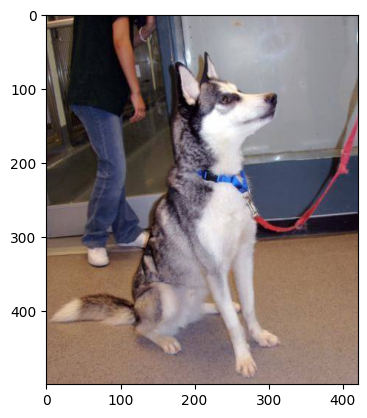

Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set
Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/training_set/training_set


In [3]:
import kagglehub

# Download latest version
dataset_sintetico_treino_diretorio = kagglehub.dataset_download("zarkonium/synthetic-image-dataset-cats-dogs-bikes-cars") #baixa o dataset sintético usado no artigo original

print("Path to dataset files:", dataset_sintetico_treino_diretorio)

dataset_real_diretorio = kagglehub.dataset_download("tongpython/cat-and-dog") #baixa um dataset de teste real

dataset_teste_diretorio = dataset_real_diretorio + "/test_set/test_set"

dataset_real_treino_diretorio = dataset_real_diretorio + "/training_set/training_set"

plt.imshow(plt.imread(dataset_teste_diretorio + "/dogs/dog.4001.jpg"))
plt.show()

print("Path to dataset files:", dataset_teste_diretorio)
print("Path to dataset files:", dataset_real_treino_diretorio)

###Definindo hiper-parâmetros

In [4]:
train_dataset_path = dataset_sintetico_treino_diretorio #define se o modelo será treinado com o dataset sintético ou real (escolher entre as variaveis dataset_real_treino_diretorio ou dataset_sintetico_treino_diretorio)


model_type = "VGG_16" #Escolha 'VGG_16' ou 'Resnet_50

activation_function = "gelu" #Se aplica apenas para a camada adicionada de 128 neurôneos


defined_image_dimensions = (256, 256)
defined_batch_size = 32
defined_epochs = 2


###Este código abaixo cria uma rede VGG-16 pre treinada no dataset imaginet e adiciona uma camada de 128 neuronios no final.

link de referencia: "https://colab.research.google.com/github/Vimukthi-Nuwan/Deep_Learning/blob/Experiment/Cat_vs_Dog_Classifier/DL2_Final_Code.ipynb#scrollTo=IQMTZft1w_lk"


In [5]:
data_transformations = keras.Sequential(
    [
        #chamadas apenas no treinamento
        keras.layers.RandomFlip("horizontal_and_vertical"), #aplica um flip vertical e ou horizontal aleatoriamente
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomTranslation(0.1, 0.1),

    ]
)

In [6]:
def build_model(input_shape=(defined_image_dimensions[0],defined_image_dimensions[1],3 )): #O input shape é (Largura, altura, numero de canais da imagem)


    #O codigo comentado abaixo fixa uma seed, tirando a aleatoriedade e viabilizando a avaliação do impacto dos parâmetros de randomização
    '''
    SEED = 123
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    '''

    if model_type == "VGG_16":
      base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == "Resnet_50":
      base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
      raise ValueError(f"valor atribuido à variável model_type desconhecido: {model_type}. Escolha 'VGG_16' ou 'Resnet_50'.")

    base_model.trainable = False #isso impede que os kernels aprendidos no pré treinamento sejam alterados pelo que eu vou fazer neste código, ou seja, garante o transfer learning

    model = keras.Sequential() #cria uma rede neural vazia, sem nenhuma camada

    model.add(data_transformations)#aplica transformações no dataset de entrada (rotaciona, da zoom, etc...)

    model.add(base_model) #adiciona a VGG-16 pré treinada sem as camadas completamente conectadas


    #model.add(keras.layers.GlobalAveragePooling2D())# Acho que o artigo original não usa esse pooling. Conferir!
    model.add(keras.layers.GlobalMaxPooling2D())# usando o Max pooling, pois o artigo não define qual usou e o max polling é o utilizado no modelo original de VGG
    model.add(keras.layers.Dense(128, activation=activation_function)) #o artigo original usa relu
    model.add(keras.layers.Dropout(0.3)) # usar apenas depois (conferir o artigo de referencia CaesEGatos).  Desliga aleatoriamente 30% dos neuronios (como se treinasse varias redes simultâneamente)
    model.add(keras.layers.Dense(1, activation='sigmoid')) #Camada de saída com apenas 1 neurônio (classificação binária).

    return model

# Create VGG16 model
model = build_model()
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001)) #compila o modelo, ou seja, agora ele está finalizado e pronto para treinamento

# Display model architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

###Agora precisamos carregar os datasets de treinamento e teste a partir do diretório base.
-Usaremos a classe tensorflow.keras.preprocessing.image_dataset_from_directory()

-Note que apenas criamos um dataset de treinamento com os dados sintéticos, pois como o objetivo é extrapolar para dados reais, os dados de teste serão advindos de um dataset de imagens reais


In [7]:
dataset_treino, dataset_sintetico_validacao = keras.preprocessing.image_dataset_from_directory(
    train_dataset_path, #define o diretório de onde serão tiradas as imagens de treinamento
    labels = 'inferred',
    label_mode = 'int',
    class_names = ["cats","dogs"], #obriga a função a considerar apenas as pastas que contem cats e dogs como nome
    color_mode = 'rgb',
    batch_size = defined_batch_size, #define quantas imagens serão passadas à rede neural antes de ajustar novamente os parâmetros via backpropagation
    image_size = defined_image_dimensions,
    shuffle = True, #embaralha as imagens
    seed = 123,
    validation_split = 0.2,
    subset = "both",
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False,
    pad_to_aspect_ratio = False,
    data_format = None,
    verbose = True
)


dataset_teste = keras.preprocessing.image_dataset_from_directory(
    dataset_teste_diretorio, #define o diretório de onde serão tiradas as imagens de teste
    labels = 'inferred',
    label_mode = 'int',
    class_names = ["cats","dogs"],
    color_mode = 'rgb',
    batch_size = 1, # Usei um no teste pois quero o resultado de cada uma das imagens!!!
    image_size = defined_image_dimensions,
    shuffle = True, #embaralha as imagens
    seed = None, #mudar para None se quiser aleatoriedade
    validation_split = None,
    subset = None,
    interpolation ='bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False,
    pad_to_aspect_ratio = False,
    data_format = None,
    verbose = True
)

#dataset_treino = dataset_treino.take(30)
#dataset_sintetico_validacao = dataset_treino.take(30)
#dataset_treino.batch(defined_batch_size)
#dataset_teste = dataset_teste.take(100)


#print(dataset_treino.class_names)
#print(dataset_teste.class_names)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Using 4000 files for validation.
Found 2023 files belonging to 2 classes.


###Agora vamos printar as imagens para ver exemplos das imagens dos datasets de treino e teste

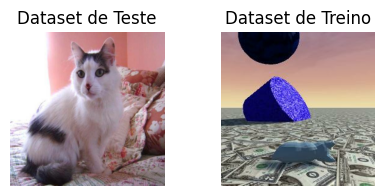

In [8]:
imagem_teste = next(iter(dataset_teste))[0][0].numpy().astype("uint8")
imagem_treino = next(iter(dataset_treino))[0][0].numpy().astype("uint8")

fig, ax = plt.subplots(1, 2, figsize=(5, 2))

ax[1].imshow(imagem_treino)
ax[1].set_title("Dataset de Treino")
ax[1].axis('off')

ax[0].imshow(imagem_teste)
ax[0].set_title("Dataset de Teste")
ax[0].axis('off')

plt.show()

###O codigo abaixo faz o teste da VGG-16 modificada com o transfer learning, mostrando a acurácia final na generalização para imagens reais.

In [ ]:
loggerName = model_type + "_model_sintetico_" + str(len(dataset_treino)*defined_batch_size) + "_" + str(defined_batch_size) + "_" + str(defined_epochs) + ".csv"
csv_logger = keras.callbacks.CSVLogger(loggerName)

history = model.fit(
        dataset_treino,
        epochs = defined_epochs,
        verbose = 1, #permite visualizar as métricas de treinamento em tempo real
        callbacks = [csv_logger], #adiciona o arquivo looger como o diretório de saida dos callbacks do modelo
        validation_data=dataset_sintetico_validacao, #usa o dataset de validação sintético
)

print(history.history)

test_loss, test_accuracy = model.evaluate(dataset_teste) #Testa o modelo treinado no dataset de teste e joga os valores de perda e da acurácia em variáveis
model.summary()

Epoch 1/2
 39/500 ━━━━━━━━━━━━━━━━━━━━ 2:05:38 16s/step - accuracy: 0.5407 - loss: 14.2563

###A celula abaixo adiciona a linha contendo as métricas da avaliação de teste no log.csv

In [ ]:
import csv

nova_linha = ['Test_metrics', test_accuracy, test_loss]

with open(loggerName, 'a', newline='') as f:

    writer = csv.writer(f) # Cria um objeto 'writer' para escrever no CSV

    for _ in range(3):
        writer.writerow([]) # Escreve uma linha vazia

    writer.writerow(nova_linha) #Escreve a linha com as metricas do teste

###A célula abaixo salva o modelo treinado e da nome ao arquivo baseado nos hyperparâmetros usados

In [ ]:
model_name = model_type + "_model_sintetico_" + str(len(dataset_treino)*defined_batch_size) + "_" + str(defined_batch_size) + "_" + str(defined_epochs) + "_" + str(round(test_accuracy,3)) + "_" + str(round(test_loss,3))
print(model_name)
model.save(model_name + ".keras", include_optimizer=True)

print(str(test_accuracy) + " " + str(test_loss))


In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.title('model val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.ylim(0.5, 1)
plt.show()


plt.plot(history.history['val_loss'])
plt.ylim(0, 0.7)
plt.show()
